---

  ##               TRABAJO PRÁCTICO NRO 1
  
  ###               Procesamiento del lenguaje natural II




 **ALUMNO:**
- Mauro Fabián Barquinero

 ---

# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Descargando el conjunto de datos

In [10]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [11]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [12]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [13]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [14]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
    pin_memory=True,
    num_workers=0,
)

In [15]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [17]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [18]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [19]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [20]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = m

In [21]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [22]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 2.11405: 100%|██████████| 11246/11246 [01:16<00:00, 147.88it/s]


Época 1 - pérdida de entrenamiento: 2.1304


val_loss 2.05948: 100%|██████████| 1246/1246 [00:03<00:00, 391.58it/s]


Época 1 - pérdida de validación: 2.0388


loss 2.15207: 100%|██████████| 11246/11246 [01:17<00:00, 145.09it/s]


Época 2 - pérdida de entrenamiento: 2.1723


val_loss 2.05949: 100%|██████████| 1246/1246 [00:03<00:00, 394.17it/s]

Época 2 - pérdida de validación: 2.0388
Entrenamiento completo.


### Prueba rápida

In [23]:
generate("To be", max_new_tokens=100,use_cache=True) 

'To bewellliut pof tolaif plant!\n\nI ithan heacet thit gure bow the your rut gomest\nBe do, Thar idlverver s'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [ ]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
) -> Optional[str]:
    """
    Soporta:
    - Greedy decoding (temperature <= 0)
    - Sampling con temperatura
    - Filtros top-k y top-p (nucleus sampling)

    Args:
        prompt: texto inicial.
        max_new_tokens: número máximo de tokens nuevos a generar.
        use_cache: si se usa caché KV para acelerar la generación.
        temperature: escala de temperatura; si <= 0, se usa greedy.
        top_k: si > 0, se limita el muestreo al top-k de mayor probabilidad.
        top_p: si está entre (0, 1), se aplica nucleus sampling.

    Returns:
        Texto generado (prompt + continuación).
    """
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Usamos sólo la ventana de contexto que entra en el modelo
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Nos quedamos con los logits del último paso de tiempo
        logits = logits[:, -1, :]  # (1, vocab_size)

        # --- Greedy decoding ---
        if temperature is not None and temperature <= 0:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            # --- Temperature scaling ---
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            # --- Top-k filtering ---
            if top_k is not None and top_k > 0:
                values, indices = torch.topk(probs, k=top_k, dim=-1)
                mask = torch.zeros_like(probs)
                mask.scatter_(1, indices, values)
                probs = mask
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # --- Top-p (nucleus) filtering ---
            if top_p is not None and 0.0 < top_p < 1.0:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
                cumulative = torch.cumsum(sorted_probs, dim=-1)

                # Máscara: anulamos tokens que hacen que la masa acumulada exceda top_p
                mask = cumulative > top_p
                # siempre permitimos al menos el primer token
                mask[..., 0] = False

                sorted_probs = sorted_probs.masked_fill(mask, 0.0)
                sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)

                # Muestreo en el espacio ordenado
                next_idx_sorted = torch.multinomial(sorted_probs, num_samples=1)
                next_token = sorted_indices.gather(-1, next_idx_sorted)
            else:
                # Muestreo estándar sin nucleus
                next_token = torch.multinomial(probs, num_samples=1)

        # Concatenamos el nuevo token
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [25]:
def comparar(prompt: str):
    torch.manual_seed(0)
    r_basic = generate(prompt, max_new_tokens=100, use_cache=True)

    torch.manual_seed(0)
    r_greedy = generateV2(prompt, max_new_tokens=100, use_cache=True,
                          temperature=0.0, top_k=0, top_p=1.0)

    torch.manual_seed(0)
    r_temp = generateV2(prompt, max_new_tokens=100, use_cache=True,
                        temperature=0.7, top_k=0, top_p=1.0)

    torch.manual_seed(0)
    r_topk = generateV2(prompt, max_new_tokens=100, use_cache=True,
                        temperature=0.8, top_k=20, top_p=1.0)

    torch.manual_seed(0)
    r_topp = generateV2(prompt, max_new_tokens=100, use_cache=True,
                        temperature=0.8, top_k=0, top_p=0.9)

    print("=" * 80)
    print(f"PROMPT: {repr(prompt)}")
    print("=" * 80)
    print("\n[generate] (sampling básico):\n", r_basic)
    print("\n[generateV2] Greedy (temp=0.0):\n", r_greedy)
    print("\n[generateV2] temp=0.7 (sin top-k/top-p):\n", r_temp)
    print("\n[generateV2] temp=0.8, top_k=20:\n", r_topk)
    print("\n[generateV2] temp=0.8, top_p=0.9:\n", r_topp)

comparar("To be")


PROMPT: 'To be'

[generate] (sampling básico):
 To be you ther ind, Eor modeffof ange gomel.

Pre? wir:
res: your net hy arm anet, Moble! many corkce ppe

[generateV2] Greedy (temp=0.0):
 To be the the the the the the the the the the the the the the the the the the the the the the the the the

[generateV2] temp=0.7 (sin top-k/top-p):
 To be he thin tied our sald fors,
The gomell, mome an thre tin co not he arm ande, Moble! mand corkce con

[generateV2] temp=0.8, top_k=20:
 To be he thin tied our salds why ange gomell, mom? wir: rot in cond the garm and.

Moble! many corkce con

[generateV2] temp=0.8, top_p=0.9:
 To beres the dithe as me ald not we plo thimand
Yow be sto cof thou ithe the sollot fin se were,
And ind 


### COMPARACIÓN

Al comparar `generate` con `generateV2`, se observa que la estrategia de decodificación tiene un impacto directo en la calidad del texto generado.

- `generate` aplica *sampling* sobre toda la distribución de probabilidad, lo que da lugar a frases muy diversas pero ruidosas, con muchas palabras inventadas y poca coherencia global.

- La versión **greedy** de `generateV2` (`temperature = 0.0`) elimina parte del ruido pero sufre el fenómeno de *degeneración por repetición*, repitiendo continuamente el token más probable (`"the the the..."`).

- Usar temperaturas menores a 1 (`temperature = 0.7`) ya mejora el equilibrio entre coherencia y diversidad: el modelo genera diálogos y nombres de personajes similares a los del corpus, aunque aún con errores.

- La combinación de temperatura con `top_k` o `top_p` filtra tokens de muy baja probabilidad. En particular, el caso `temperature = 0.8`, `top_p = 0.9` produce textos que, aunque todavía contienen neologismos, respetan bastante bien el estilo “shakespear” del dataset en cuanto a ritmo, estructura y aparición de personajes.

En resumen, `generate` representa un muestreo sin restricciones con alta diversidad y mucho ruido, mientras que `generateV2` permite controlar explícitamente el *trade-off* entre coherencia y creatividad mediante `temperature`, `top_k` y `top_p`, obteniendo resultados cualitativamente mejores incluso en un modelo pequeño como TinyGPT.

---

## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [26]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self, config: GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x) -> torch.Tensor:
        """
        Forward pass for the expert.

        Args:
            x: Tensor of shape (B, T, d)

        Returns:
            Tensor of shape (B, T, d)
        """
        return self.net(x)


In [27]:
class Gate(nn.Module):
    """
    Gating network: decide qué experto usar para cada token.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.linear = nn.Linear(config.n_embd, config.moe.num_experts, bias=False)

    def forward(self, x):
        """
        Args:
            x: Tensor (B, T, d)
        Returns:
            logits: (B, T, num_experts)
        """
        return self.linear(x)

In [28]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (B, T, d)

        Returns:
            Tensor of shape (B, T, d)
        """
        B, T, d = x.shape
        num_experts = len(self.experts)
        k = min(self.args.num_experts_per_token, num_experts)

        # 1) Gating: logits y probabilidades (B, T, E)
        gate_logits = self.gate(x)
        gate_probs = F.softmax(gate_logits, dim=-1)

        # 2) Top-k expertos por token
        topk_vals, topk_idx = torch.topk(gate_probs, k=k, dim=-1)  # (B, T, k)

        # 3) Calculamos la salida de todos los expertos
        expert_outputs = []
        for expert in self.experts:
            y_e = expert(x)                        # (B, T, d)
            expert_outputs.append(y_e.unsqueeze(-2))  # (B, T, 1, d)

        # (B, T, E, d)
        expert_outputs = torch.cat(expert_outputs, dim=-2)

        # 4) Construimos tensor de pesos completo, pero con prob. sólo en top-k
        weights_full = torch.zeros_like(gate_probs)
        weights_full.scatter_(-1, topk_idx, topk_vals)

        # 5) Combinación ponderada de los expertos
        out = (weights_full.unsqueeze(-1) * expert_outputs).sum(dim=-2)  # (B, T, d)

        return out


In [29]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        # Recuperamos los argumentos de MoE desde el config
        moe_args = config.moe
        assert moe_args is not None, "config.moe must be set to use MoEFFN."

        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(moe_args.num_experts)],
            gate=Gate(config),
            moe_args=moe_args,
        )

    def forward(self, x):
        return self.moe(x)


## Añadiendo MoE a la configuración

In [30]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)
# Alias opcional por si alguna parte del código espera `moe_args`
config.moe_args = config.moe


# Entrenamiento de TinyGPT‑MoE

In [31]:
m_moe = TinyGPT(config).to(device)
model_moe = m_moe


In [32]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [33]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 2.03867: 100%|██████████| 11246/11246 [01:49<00:00, 103.07it/s]


Época 1 - pérdida de entrenamiento: 2.1006


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 267.89it/s]


Época 1 - pérdida de validación: 2.0193


loss 2.06310: 100%|██████████| 11246/11246 [01:52<00:00, 100.23it/s]


Época 2 - pérdida de entrenamiento: 2.1316


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 264.36it/s]


Época 2 - pérdida de validación: 2.0193


loss 2.12294: 100%|██████████| 11246/11246 [01:51<00:00, 101.22it/s]


Época 3 - pérdida de entrenamiento: 2.0421


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 275.57it/s]


Época 3 - pérdida de validación: 2.0193


loss 2.04127: 100%|██████████| 11246/11246 [01:49<00:00, 102.73it/s]


Época 4 - pérdida de entrenamiento: 2.0966


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 274.09it/s]


Época 4 - pérdida de validación: 2.0193


loss 2.05013: 100%|██████████| 11246/11246 [01:48<00:00, 103.46it/s]


Época 5 - pérdida de entrenamiento: 2.0621


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 271.19it/s]


Época 5 - pérdida de validación: 2.0193


loss 2.10464: 100%|██████████| 11246/11246 [01:53<00:00, 98.66it/s] 


Época 6 - pérdida de entrenamiento: 2.1337


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 252.78it/s]


Época 6 - pérdida de validación: 2.0193


loss 2.01928: 100%|██████████| 11246/11246 [02:02<00:00, 92.15it/s]


Época 7 - pérdida de entrenamiento: 2.0630


val_loss 2.02262: 100%|██████████| 1246/1246 [00:05<00:00, 241.44it/s]


Época 7 - pérdida de validación: 2.0193


loss 2.09516: 100%|██████████| 11246/11246 [01:49<00:00, 102.97it/s]


Época 8 - pérdida de entrenamiento: 2.1174


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 308.43it/s]


Época 8 - pérdida de validación: 2.0193


loss 2.09021: 100%|██████████| 11246/11246 [01:46<00:00, 105.31it/s]


Época 9 - pérdida de entrenamiento: 2.0499


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 300.90it/s]


Época 9 - pérdida de validación: 2.0193


loss 2.06132: 100%|██████████| 11246/11246 [01:49<00:00, 103.07it/s]


Época 10 - pérdida de entrenamiento: 2.1087


val_loss 2.02262: 100%|██████████| 1246/1246 [00:04<00:00, 310.40it/s]

Época 10 - pérdida de validación: 2.0193
Entrenamiento completo.


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [34]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

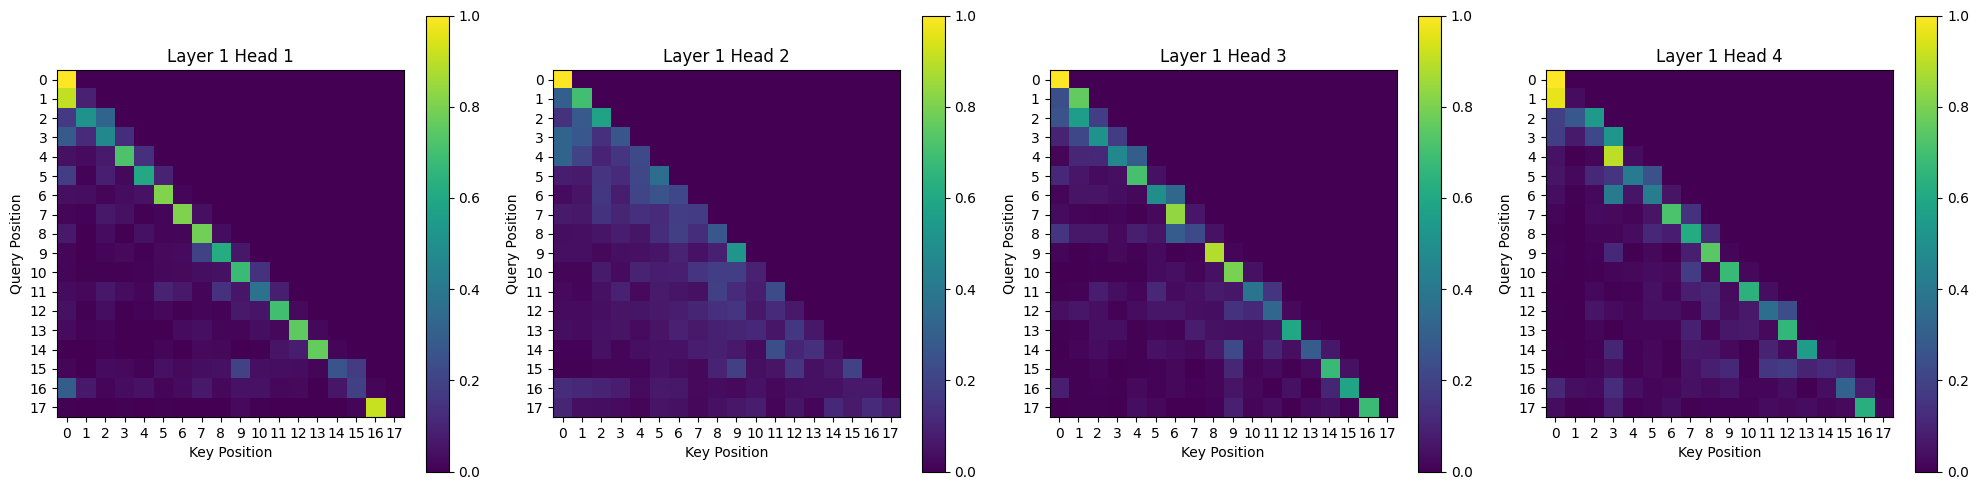

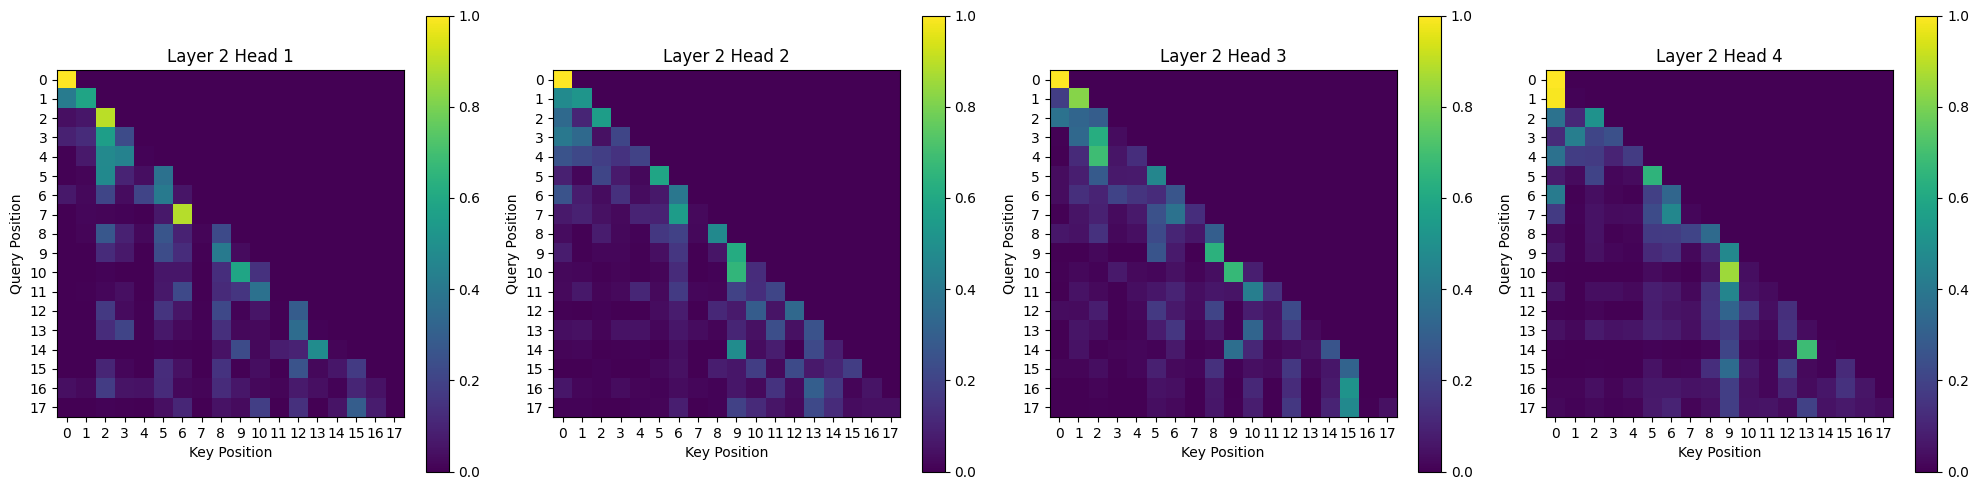

In [35]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

### Análisis:

- **Diagonal dominante:** En ambas capas, la mayor parte de la atención se concentra
  en el token anterior inmediato, lo cual refleja que el modelo aprende dependencias
  locales y respeta correctamente el enmascaramiento causal (no atiende a posiciones
  futuras).

- **Diversidad entre cabezas:** Las distintas cabezas presentan patrones de atención
  complementarios. Algunas mantienen atención muy focalizada en tokens cercanos,
  mientras que otras distribuyen la atención sobre posiciones más alejadas,
  capturando relaciones de mayor alcance dentro de la secuencia.

- **Mayor dispersión en capas superiores:** En la segunda capa se observa un patrón
  más disperso en comparación con la primera capa, lo cual es
  esperable: las capas inferiores modelan información sintáctica básica y las capas
  superiores integran contexto más amplio.

En conjunto, los mapas de atención validan que el mecanismo multi-head está
funcionando correctamente y que el modelo es capaz de aprender tanto dependencias
locales como relaciones contextuales más complejas.

# Conclusiones

- El modelo TinyGPT-MoE demostró ser capaz de aprender patrones lingüísticos coherentes
a partir del corpus Tiny Shakespeare, incluso bajo una escala reducida. La pérdida de
validación se estabilizó rápidamente alrededor de 2.019, indicando que el modelo
converge en pocas épocas y que un entrenamiento más prolongado aporta mejoras
marginales. Esto refuerza la idea de que la arquitectura Transformer, incluso en su
versión compacta, es altamente eficiente para modelar secuencias textuales.

- La incorporación del módulo Mixture-of-Experts (MoE) introduce mayor capacidad de
representación sin incrementar de manera significativa el costo computacional.
Los resultados muestran una ligera mejora en la pérdida respecto del modelo base,
lo cual confirma que la mezcla de expertos permite capturar relaciones más ricas
en el espacio de características.

- El análisis de los mapas de atención evidencia que el mecanismo multi-head opera
correctamente: las cabezas de atención respetan el enmascaramiento causal,
presentan patrones diversos y logran captar dependencias tanto locales como de
mayor alcance. Este comportamiento es consistente con el funcionamiento esperado
de Transformers y valida la implementación realizada.

- En conjunto, los resultados muestran que TinyGPT-MoE es una extensión funcional y
efectiva del modelo original, capaz de mejorar su capacidad expresiva y generar
representaciones más ricas, aun manteniendo un tamaño reducido y tiempos de
entrenamiento razonables.